# Practical session n°5

Notions:
- Semantic segmentation
- Intersection over Union
- Image Denoising
- Fully convolutional networks, U-Net
- Weak supervision (in part II): The noise-to-noise and the Neural Eggs Separation scenarios.

Duration: 1 h 30 + 2 h

In P3, we illustrated how Convolutional Neural Networks (CNNs) are trained for image classification tasks. In this practical session, we demonstrate how to achieve pixel-level predictions for tasks like semantic segmentation and image denoising.

To start, we’ll simply apply an off-the-shelf model. Then, we’ll focus on training a model from scratch (part I, exercise 2 and part II).

In P3, we also introduced a crucial set of methods known as "transfer learning," which is particularly effective when there’s limited training data. In this session, we’ll explore another equally important set of methods called "weak supervision," which is well-suited for cases where ground truth is imperfectly known (Part II).

## Part II: denoising with FCN - weakly-supervised approaches




In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

First, import the functions contained in the "utile" module.

In [14]:
! git clone https://github.com/nanopiero/ML_S5_etudiants
! cp ML_S5_etudiants/practicals/P5/utile.py .
from utile import gen_noise2noise, voir_batch2D, UNet

fatal: destination path 'ML_S5_etudiants' already exists and is not an empty directory.


###**Exercise 1: The "noise to noise" scenario**

In Exercise 2, Part I, we had pairs (noisy version, clean version) to learn from. However, in real-world applications, clean versions are barely available. \
Sometimes, there are instances where multiple noisy versions are accessible. Consider, for example, photos taken with a telephoto lens with several seconds between shots: the effects of air turbulence on image quality are independent from one image to another. \
In the "noise to noise" scenario [(Lehtinen,2018)](https://arxiv.org/pdf/1803.04189.pdf), we have pairs of noisy images, organized into two sets $B^1_{noisy}$ and $B^2_{noisy}$.
To situate ourselves in this scenario, we utilize the synthetic images from Exercise 1. The *gen_noise2noise* function allows us to sample from both datasets:

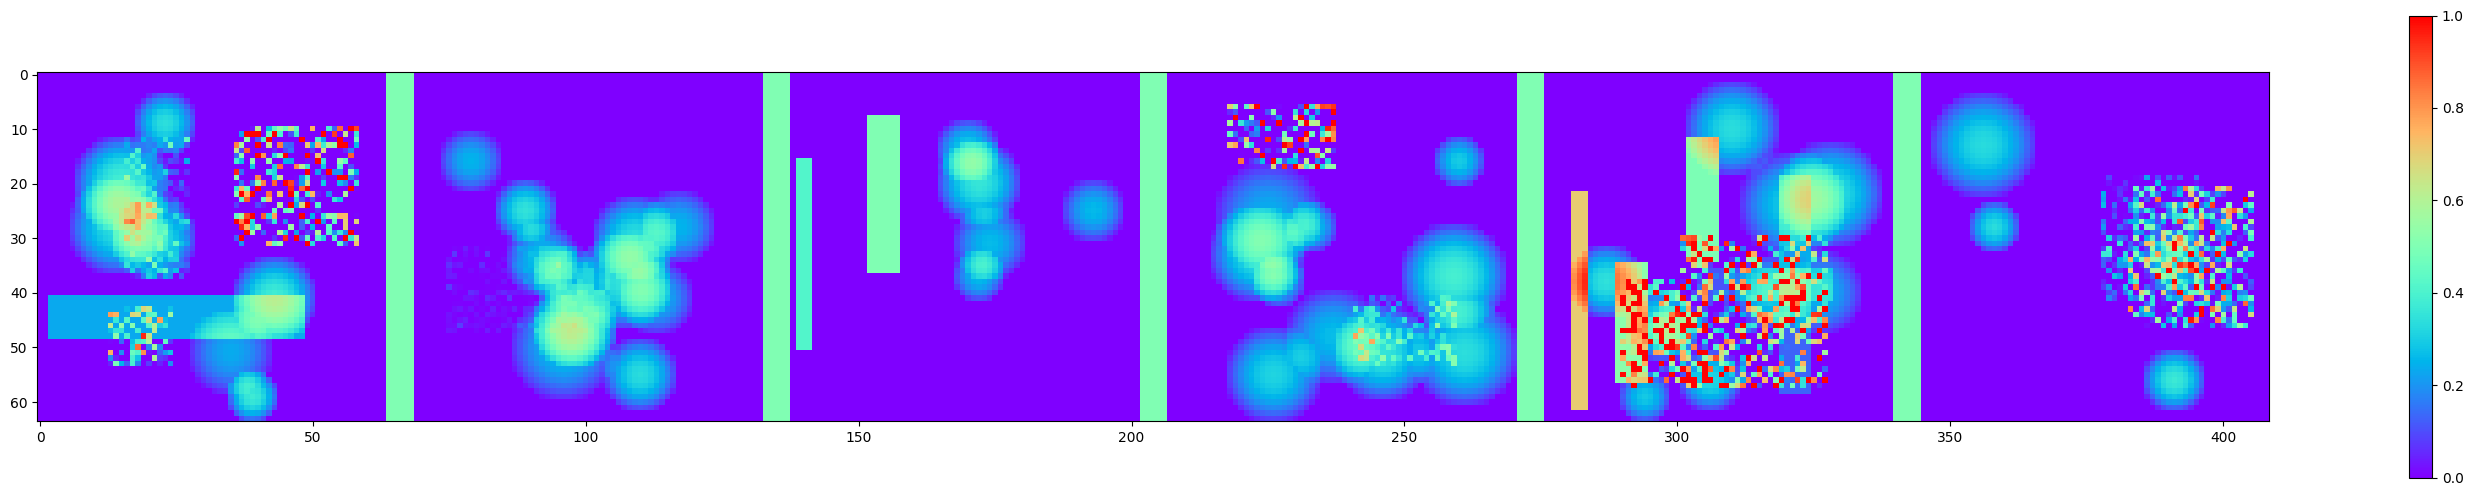

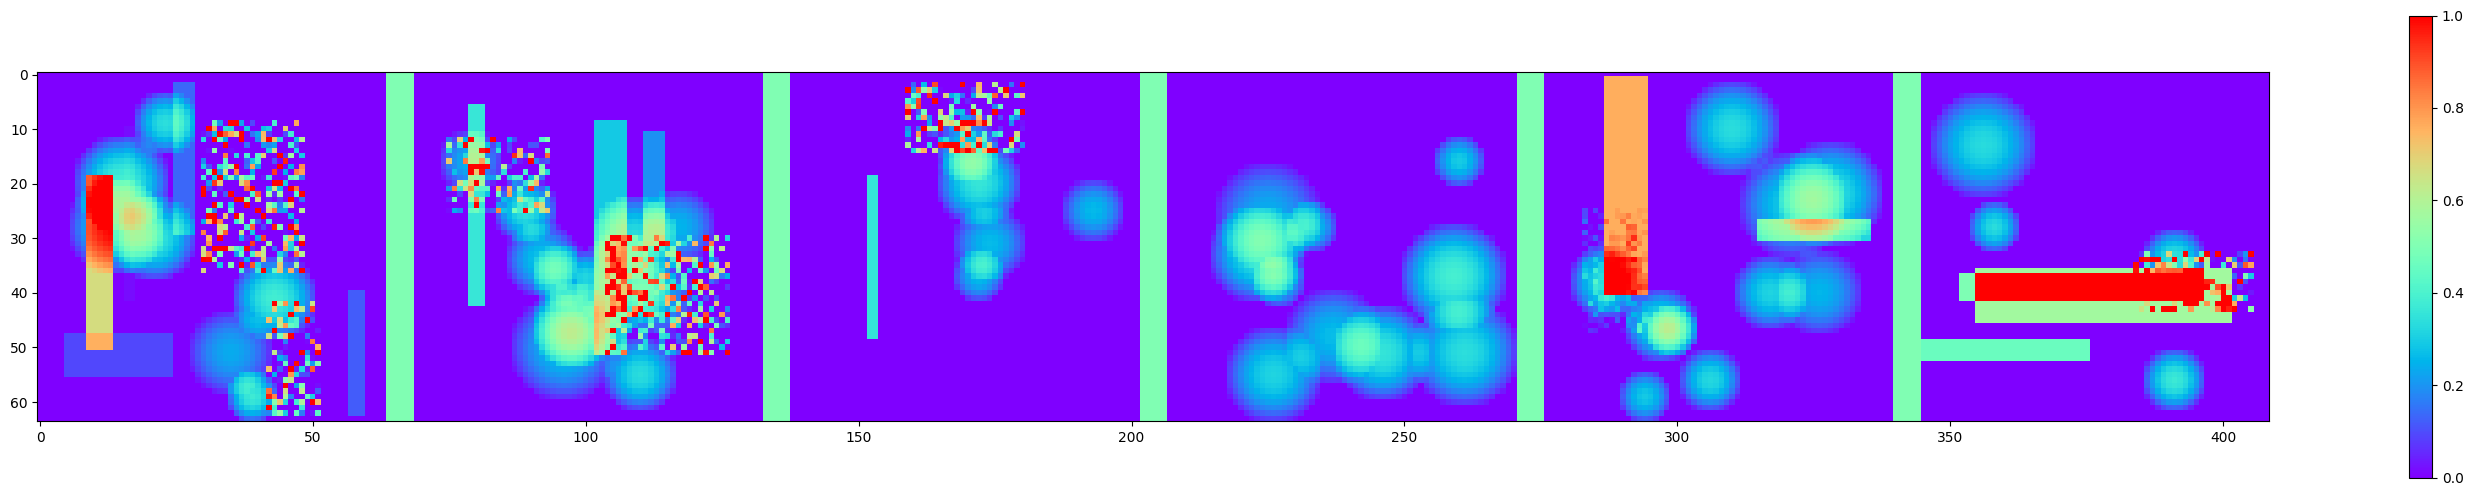

In [20]:
image1, image2 = gen_noise2noise(6)
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(image2.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1:** Define a learning procedure that effectively denoises the image.

In [15]:
fcn = UNet(1,1,16).cuda()

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [27]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [32]:
nepochs = 40
nbatches = 100
batchsize = 64
loss_fn = nn.L1Loss()

for epoch in range(nepochs):
    print('epoch :' + str(epoch))

    # Training
    for i in range(nbatches):
      input, target = gen_noise2noise(batchsize)
      input = input.to(device)
      target = target.to(device)
      optimizer.zero_grad()
      output = fcn(input)
      l = loss_fn(output, target)
      l.backward()
      optimizer.step()

epoch :0
epoch :1
epoch :2
epoch :3
epoch :4
epoch :5
epoch :6
epoch :7
epoch :8
epoch :9
epoch :10
epoch :11
epoch :12
epoch :13
epoch :14
epoch :15
epoch :16
epoch :17
epoch :18
epoch :19
epoch :20
epoch :21
epoch :22
epoch :23
epoch :24
epoch :25
epoch :26
epoch :27
epoch :28
epoch :29
epoch :30
epoch :31
epoch :32


KeyboardInterrupt: 

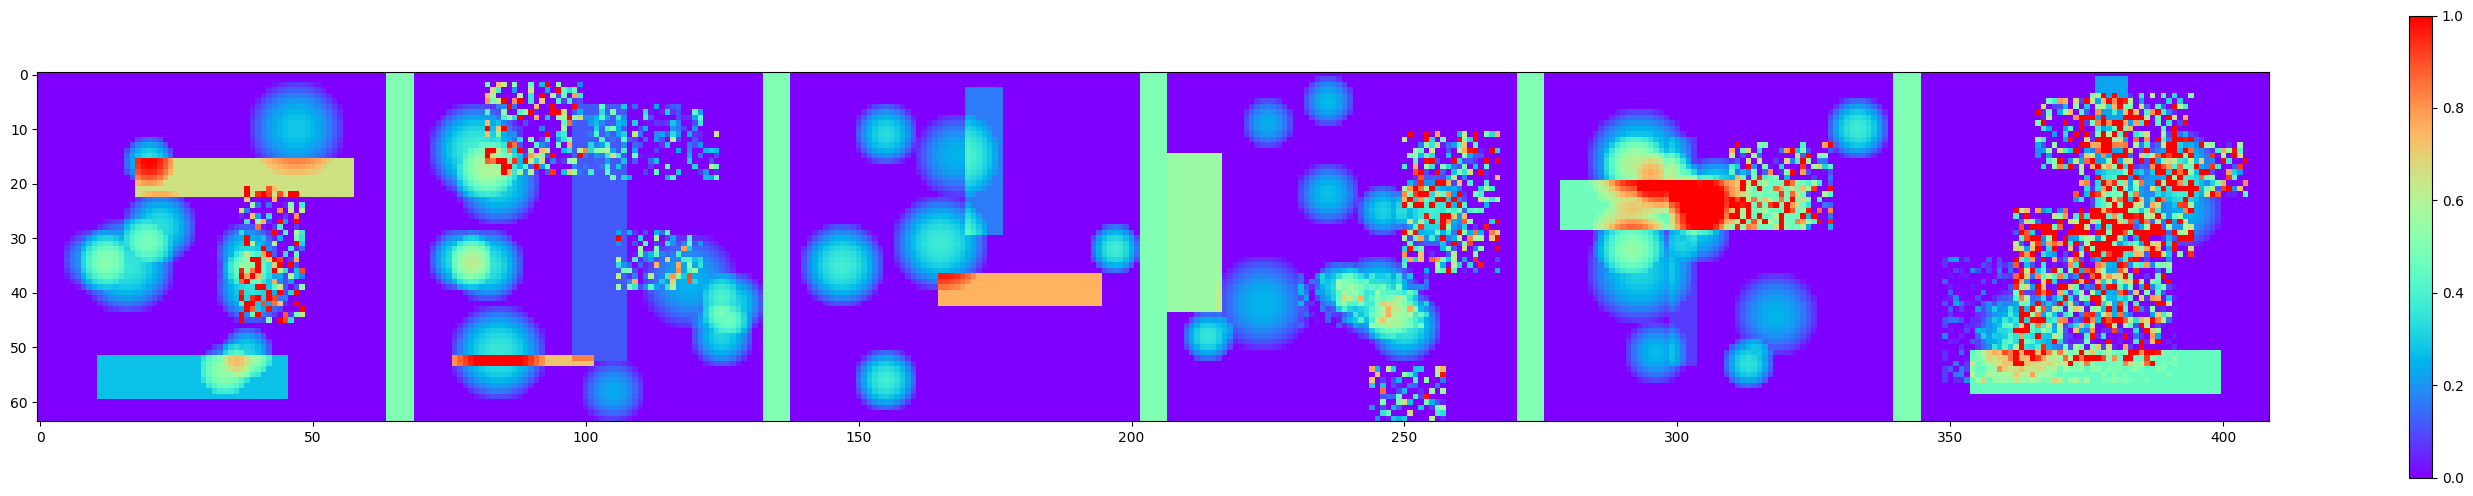

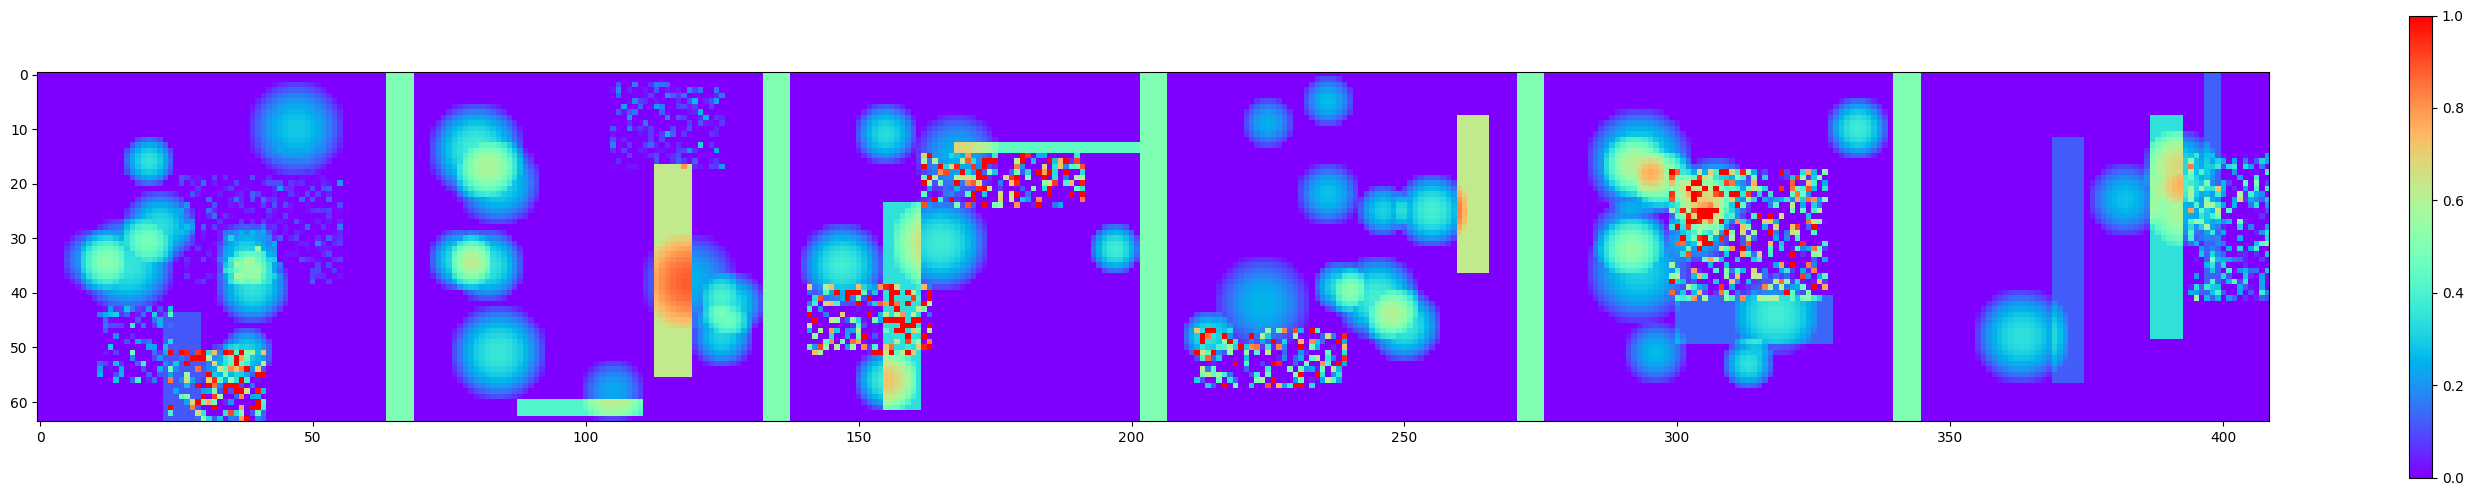

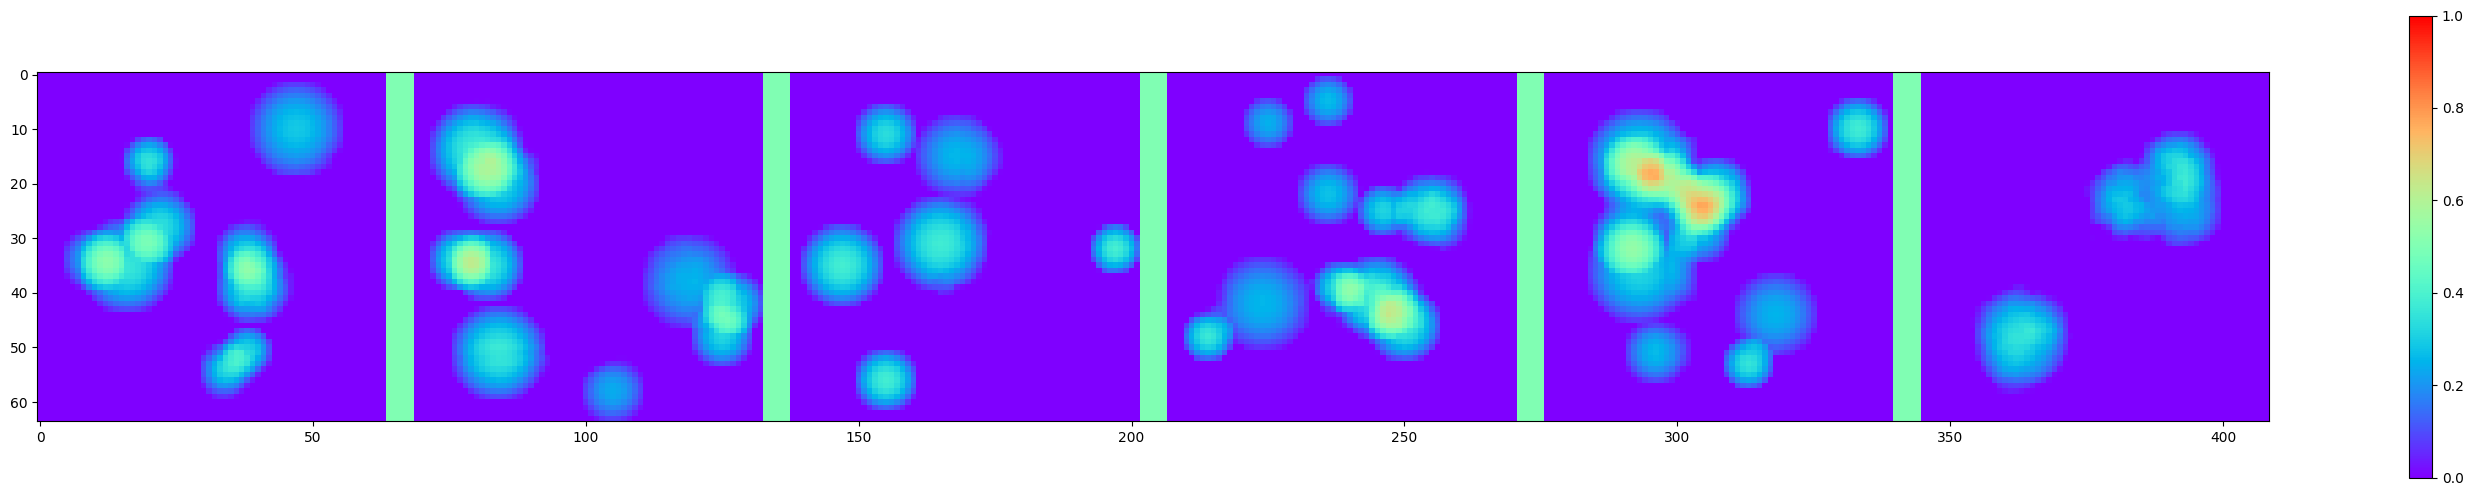

In [33]:
# viz:
fcn.eval()

input, target = gen_noise2noise(6)

output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)  # inputs
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)  # targets
fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1) # outputs


**Q2:** Theoretical analysis:

The training procedure involves searching for the weights $\theta^*$ that satisfy:

\begin{equation}
\theta^* = \underset{\theta}{argmin} {\big \{} \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] {\big \}} \tag{1}
\end{equation}

Rewrite $\mathbb{E}_{(X,Y)}[ \mathcal{L} (f_\theta(X), Y) ]$ to justify the approach taken for **Q1**.



...


###**Exercise 2: The "NES" scenario (Neural Egg Separation)**

In another scenario, two sources of images can be sampled independently. The first provides noisy images containing the object of interest. Images from the second source contain only noise. Additionally, the corruption process, i.e., how the noise is combined with the clean image, is assumed to be known. This is a relatively common scenario. For instance, in the case of meteorological radar images, it is possible to extract images containing only noise during non-precipitation periods.

This scenario was defined by [Halperin et al (2018)](https://arxiv.org/pdf/1811.12739.pdf). These authors propose an iterative method to address it (Neural Egg Separation). In this exercise, we will rely on a fairly similar principle, still using our synthetic images.

The functions gen1_NES and gen2_NES allow sampling from the two sources. The corruption process is trivial: the noise (rectangles) is simply added to the clean image (cells).   



In [ ]:
image1 = gen1_NES(6)
noise = gen2_NES(6)

# sample noisy pictures:
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

# sample noise:
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(noise, 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1:** Propose a learning strategy that leads to effective denoising.

**Q2:** Discuss the limitations of the method and mention some avenues for improvement.